#  추천 시스템 - High Cardinallity

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob

from pprint import pprint
import json

import warnings
warnings.filterwarnings('ignore')

`(3) SQLite DB`

In [3]:
from langchain_community.utilities import SQLDatabase

# ETF 데이터베이스 연결
db = SQLDatabase.from_uri(
    "sqlite:///etf_database.db",
    )

# 사용 가능한 테이블 목록 
print(db.dialect)
print(db.get_usable_table_names())
etfs = db.run("SELECT * FROM ETFs LIMIT 5;")

for etf in eval(etfs):
    print(etf)

sqlite
['ETFs', 'ETFsInfo']
('466400', '1Q 25-08 회사채(A+이상)액티브', '2023/09/19', '채권-회사채-단기', '하나자산운용', 4.52, 'KIS 2025-08만기형 크레딧 A+이상 지수(총수익)', 0.11, 111916276404.0, 0.03, '매우낮음', '실물(액티브)', 0.1, '배당소득세(보유기간과세)')
('491610', '1Q CD금리액티브(합성)', '2024/09/24', '기타', '하나자산운용', 0.0, 'KIS 하나 CD금리 총수익지수', 0.05, 316206006696.0, 0.02, '매우낮음', '합성(액티브)', 0.02, '배당소득세(보유기간과세)')
('451060', '1Q K200액티브', '2023/01/31', '주식-시장대표', '하나자산운용', -3.66, '코스피 200', 0.77, 99754348820.0, -0.01, '높음', '실물(액티브)', 0.18, '배당소득세(보유기간과세)')
('463290', '1Q 단기금융채액티브', '2023/08/03', '채권-혼합-단기', '하나자산운용', 4.01, 'MK 머니마켓 지수(총수익)', 0.05, 252717462257.0, 0.0, '매우낮음', '실물(액티브)', 0.08, '배당소득세(보유기간과세)')
('479080', '1Q 머니마켓액티브', '2024/04/02', '채권-혼합-단기', '하나자산운용', 0.0, 'KIS-하나 MMF 지수(총수익)', 0.06, 308255065986.0, -0.01, '매우낮음', '실물(액티브)', 0.05, '배당소득세(보유기간과세)')


## **고유명사 처리** 

- **고유명사** 처리를 위한 **벡터 스토어** 구축

- 사용자 질문 내 고유명사 **맞춤법 자동 검증** 기능

- 정확한 **엔티티 매칭**을 통한 쿼리 정확도 향상

- 벡터 기반 고유명사 자동 검증으로 검색 정확도 개선

- 참조: https://python.langchain.com/docs/tutorials/sql_qa/

### 1) **SQL QA Chain** 구현

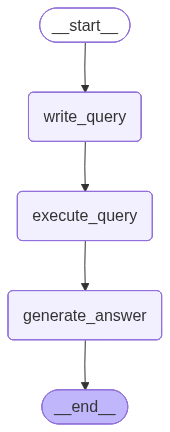

In [4]:
from typing import Annotated, TypedDict
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain_community.tools import QuerySQLDatabaseTool
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import START, StateGraph 
from IPython.display import Image, display

# 상태 정보를 저장하는 State 클래스
class State(TypedDict):
    question: str  # 입력 질문
    query: str     # 생성된 쿼리
    result: str    # 쿼리 결과
    answer: str    # 생성된 답변

# llm 모델 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# sql 쿼리 생성 프롬프트 템플릿 생성
query_prompt_template = ChatPromptTemplate.from_messages([
    ("system", """
    Given an input question, create a syntactically correct {dialect} query to run to help find the answer. 
    Unless the user specifies in his question a specific number of examples they wish to obtain, 
    always limit your query to at most {top_k} results.
      
    You can order the results by a relevant column to return the most interesting examples in the database.
    Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.
    Pay attention to use only the column names that you can see in the schema description. 
    Be careful to not query for columns that do not exist.
      
    Also, pay attention to which column is in which table.
    Only use the following tables:
    {table_info}
    """),
    ("user", """
    Question:
    {input}
    """)
])


# SQL 쿼리 생성 함수
class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]

def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

# SQL 쿼리 실행 함수
def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

# 답변 생성 함수
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}


# 상태 그래프 생성
graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

# 상태 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
# 고유명사를 사용하는 쿼리 테스트 - 운용사
for step in graph.stream(
    {"question": "KB에서 운용하는 ETF는 모두 몇개인가요?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT COUNT(*) AS 운용사_ETF_개수 FROM ETFs WHERE 운용사 LIKE '%KB%';"}}
{'execute_query': {'result': '[(0,)]'}}
{'generate_answer': {'answer': 'KB에서 운용하는 ETF는 없습니다.'}}


In [6]:
# 고유명사를 사용하는 쿼리 테스트 - 운용사
for step in graph.stream(
    {"question": "케이비자산운용에서 운용하는 ETF는 모두 몇개인가요?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT COUNT(*) AS count FROM ETFs WHERE 운용사 = '케이비자산운용'"}}
{'execute_query': {'result': '[(118,)]'}}
{'generate_answer': {'answer': '케이비자산운용에서 운용하는 ETF는 모두 118개입니다.'}}


In [7]:
# 고유명사를 사용하는 쿼리 테스트 - ETF
for step in graph.stream(
    {"question": "Dow Jones ETF는 모두 몇개인가요?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT COUNT(*) AS DowJones_ETF_Count FROM ETFs WHERE 기초지수 LIKE '%Dow Jones%' LIMIT 10"}}
{'execute_query': {'result': '[(16,)]'}}
{'generate_answer': {'answer': 'Dow Jones ETF는 총 16개입니다.'}}


### 2) **고유명사 DB** 연동

`(1) DB 테이블에서 고유명사 추출`

In [8]:
import ast
import re

def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


etfs = query_as_list(db, "SELECT DISTINCT 종목명 FROM ETFs")
fund_managers = query_as_list(db, "SELECT DISTINCT 운용사 FROM ETFs")

# 결과 출력
print(f"ETF 종목 수: {len(etfs)}")
print(f"운용사 수: {len(fund_managers)}")

print("\n")

print(f"ETF 종목명: {etfs[:5]}")
print(f"운용사: {fund_managers[:5]}")

ETF 종목 수: 925
운용사 수: 26


ETF 종목명: ['PLUS 미국S&P500', 'TIGER 소프트웨어', 'TIMEFOLIO 코스피액티브', 'TIGER 코리아테크액티브', 'KODEX 미국30년국채액티브(H)']
운용사: ['에셋플러스자산운용', '브이아이자산운용', '유리에셋', '케이비자산운용', '하나자산운용']


`(2) 고유명사를 벡터스토어에 저장`

In [9]:
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

# 임베딩 모델 생성
# embeddings = OpenAIEmbeddings(model="text-embedding-3-small") 
embeddings = OpenAIEmbeddings(model="text-embedding-3-large") # "text-embedding-3-large" 모델 비교

# 임베딩 벡터 저장소 생성
vector_store = InMemoryVectorStore(embeddings)

# ETF 종목명과 운용사를 임베딩 벡터로 변환
_ = vector_store.add_texts(etfs + fund_managers)
retriever = vector_store.as_retriever(search_kwargs={"k": 10})

In [10]:
# 임베딩 벡터 검색 - 운용사
retriever.invoke("케이비")

[Document(id='e7605dba-83f2-44a9-9a7f-715316d173ff', metadata={}, page_content='케이비자산운용'),
 Document(id='683f5c3d-55c4-46df-94e7-153df1779583', metadata={}, page_content='KOSEF 블루칩'),
 Document(id='4669aae6-c5d3-4136-b50f-5777222be0aa', metadata={}, page_content='아이비케이자산운용'),
 Document(id='9d791cf6-7f4a-499c-ae6e-8e1177d31101', metadata={}, page_content='케이씨지아이자산운용'),
 Document(id='36d26de2-b232-4f3b-960d-870c15e0e449', metadata={}, page_content='PLUS 고배당주위클리커버드콜'),
 Document(id='c350042e-9c18-42d2-8383-bd4332e8b2a8', metadata={}, page_content='KOSEF 코리아밸류업'),
 Document(id='83ee11fa-967c-4720-8dc5-e98d316d95e9', metadata={}, page_content='KOSEF'),
 Document(id='a4aadd08-e183-4da9-b01a-dbf2ca8ff0f0', metadata={}, page_content='KOSEF 물가채KIS'),
 Document(id='fb6c82f6-fbeb-4c37-ae85-d8ca0d9d12d2', metadata={}, page_content='KODEX 바이오'),
 Document(id='55cb1eaf-b34b-43e7-87eb-7dfda336d611', metadata={}, page_content='RISE KQ고배당')]

In [11]:
# 임베딩 벡터 검색 - 운용사
retriever.invoke("KB운용")

[Document(id='4669aae6-c5d3-4136-b50f-5777222be0aa', metadata={}, page_content='아이비케이자산운용'),
 Document(id='7eba4c0b-99a1-474c-989e-747ca59fc4d6', metadata={}, page_content='비엔케이자산운용'),
 Document(id='cdf2590f-16d8-4dd2-807a-36a05aaaf785', metadata={}, page_content='PLUS 코리아밸류업'),
 Document(id='e254f0cd-7322-45ea-9a0a-993cb40a03f9', metadata={}, page_content='키움투자자산운용'),
 Document(id='e7605dba-83f2-44a9-9a7f-715316d173ff', metadata={}, page_content='케이비자산운용'),
 Document(id='83a37230-3ffd-4ca0-b485-b62e354e1e26', metadata={}, page_content='BNK 미래전략기술액티브'),
 Document(id='7c7661de-42db-4fd6-84ba-4264f0eb00ea', metadata={}, page_content='PLUS K방산'),
 Document(id='97425737-8fad-4b82-a7ee-762855e2519b', metadata={}, page_content='PLUS 고배당주'),
 Document(id='c350042e-9c18-42d2-8383-bd4332e8b2a8', metadata={}, page_content='KOSEF 코리아밸류업'),
 Document(id='6d26adec-d2b0-4351-a54f-14becd930fd5', metadata={}, page_content='BNK 온디바이스AI')]

In [12]:
# 임베딩 벡터 검색 - ETF 종목명
retriever.invoke("Dow Jones")

[Document(id='66527735-8fff-4661-a561-2d41bf77a515', metadata={}, page_content='SOL 미국배당다우존스'),
 Document(id='61d038aa-b4cc-45b5-930b-9926101068c8', metadata={}, page_content='SOL 미국배당다우존스TR'),
 Document(id='debacd17-bef1-4db2-a9b3-c42881b7f111', metadata={}, page_content='SOL 미국배당다우존스(H)'),
 Document(id='59fc78b7-b897-491c-930d-877ec1836ee4', metadata={}, page_content='PLUS 미국다우존스고배당주(합성 H)'),
 Document(id='17029ae0-df2b-487c-aec2-700a024c2cad', metadata={}, page_content='TIGER 미국배당다우존스'),
 Document(id='cdee619b-72d5-4b5e-b105-09c5b9d31467', metadata={}, page_content='KODEX 미국배당다우존스'),
 Document(id='8f96ece1-c0c5-41c1-9e94-c4444b61f265', metadata={}, page_content='ACE 미국배당다우존스'),
 Document(id='c106a60d-f511-4f95-9ce1-b6d415ee3d27', metadata={}, page_content='WON 미국S&P500'),
 Document(id='eb872311-8673-47b3-b257-6d00449c441f', metadata={}, page_content='TIGER 미국다우존스30'),
 Document(id='ebe69e47-db3f-4af6-93cf-1c137ddeabc5', metadata={}, page_content='KODEX 대만테크고배당다우존스')]

In [13]:
# 임베딩 벡터 검색 - ETF 종목명
retriever.invoke("다우존스")

[Document(id='8f96ece1-c0c5-41c1-9e94-c4444b61f265', metadata={}, page_content='ACE 미국배당다우존스'),
 Document(id='ebe69e47-db3f-4af6-93cf-1c137ddeabc5', metadata={}, page_content='KODEX 대만테크고배당다우존스'),
 Document(id='66527735-8fff-4661-a561-2d41bf77a515', metadata={}, page_content='SOL 미국배당다우존스'),
 Document(id='cdee619b-72d5-4b5e-b105-09c5b9d31467', metadata={}, page_content='KODEX 미국배당다우존스'),
 Document(id='61d038aa-b4cc-45b5-930b-9926101068c8', metadata={}, page_content='SOL 미국배당다우존스TR'),
 Document(id='debacd17-bef1-4db2-a9b3-c42881b7f111', metadata={}, page_content='SOL 미국배당다우존스(H)'),
 Document(id='17029ae0-df2b-487c-aec2-700a024c2cad', metadata={}, page_content='TIGER 미국배당다우존스'),
 Document(id='59fc78b7-b897-491c-930d-877ec1836ee4', metadata={}, page_content='PLUS 미국다우존스고배당주(합성 H)'),
 Document(id='9b818571-c878-45f6-83fe-2c5def2448c5', metadata={}, page_content='KODEX 미국배당다우존스타겟커버드콜'),
 Document(id='eb872311-8673-47b3-b257-6d00449c441f', metadata={}, page_content='TIGER 미국다우존스30')]

`(3) 검색 결과 변환하는 함수`

In [14]:
from langchain.agents.agent_toolkits import create_retriever_tool

# 검색 프롬프트 생성
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)

# 검색 도구 생성
entity_retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)

# 검색 도구 사용
print(entity_retriever_tool.invoke("KB에서 운용하는 ETF는 모두 몇개인가요?"))

KOSEF 미국ETF산업STOXX

키움투자자산운용

한국투자밸류자산운용

KODEX 미국ETF산업Top10 Indxx

KODEX iShares미국투자등급회사채액티브

케이비자산운용

KODEX iShares미국인플레이션국채액티브

KODEX iShares미국하이일드액티브

KOSEF 미국방어배당성장나스닥

KOSEF 미국나스닥100(H)


In [15]:
print(entity_retriever_tool.invoke("Dow Jones 관련 ETF는 무엇인가요?"))

KODEX 미국ETF산업Top10 Indxx

PLUS 미국다우존스고배당주(합성 H)

KODEX iShares미국인플레이션국채액티브

KODEX 미국배당다우존스

SOL 미국배당다우존스(H)

KODEX 미국배당다우존스타겟커버드콜

SOL 미국배당다우존스TR

KODEX iShares미국투자등급회사채액티브

SOL 미국배당다우존스

TIGER 미국다우존스30


`(4) 쿼리 생성하는 사용자 프롬프트 정의`

In [16]:
from langchain_core.prompts import ChatPromptTemplate

# 테이블 정보와 엔티티 관계를 포함한 프롬프트 템플릿
entity_query_template = """
Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Entity names and their relationships to consider:
{entity_info}

## Matching Guidelines
- Use exact matches when comparing entity names
- Check for historical name variations if available
- Apply case-sensitive matching for official names
- Handle both Korean and English entity names when present

Question: {input}
"""

# 새로운 ChatPromptTemplate 생성
query_prompt_template = ChatPromptTemplate.from_template(entity_query_template)

# 입력 변수 확인
print("Input variables:", query_prompt_template.input_variables)

Input variables: ['dialect', 'entity_info', 'input', 'table_info', 'top_k']


In [17]:
def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
            "entity_info": entity_retriever_tool.invoke(state["question"]),
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}


# 쿼리 실행
response = write_query({"question": "KB에서 운용하는 ETF는 모두 몇개인가요?"})

response

{'query': "SELECT COUNT(*) AS ETF_개수 FROM ETFs WHERE 운용사 = '케이비자산운용';"}

`(5) 상태 그래프 초기화`

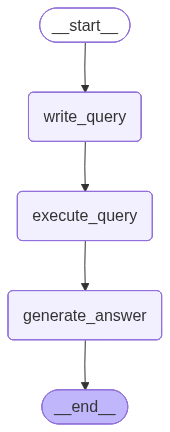

In [18]:
from langgraph.graph import START, StateGraph 

graph_builder = StateGraph(State)

graph_builder.add_node("write_query", write_query)
graph_builder.add_node("execute_query", execute_query)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "write_query")
graph_builder.add_edge("write_query", "execute_query")
graph_builder.add_edge("execute_query", "generate_answer")  
graph = graph_builder.compile()


from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
# 고유명사를 사용하는 쿼리 테스트 - 운용사
for step in graph.stream(
    {"question": "KB에서 운용하는 ETF는 모두 몇개인가요?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT COUNT(*) AS 운용하는_ETF_수 FROM ETFs WHERE 운용사 = '케이비자산운용';"}}
{'execute_query': {'result': '[(118,)]'}}
{'generate_answer': {'answer': 'KB에서 운용하는 ETF는 모두 118개입니다.'}}


In [20]:
# 고유명사를 사용하는 쿼리 테스트 - 운용사
for step in graph.stream(
    {"question": "케이비에서 운용하는 ETF는 모두 몇개인가요?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT COUNT(*) AS ETF_Count FROM ETFs WHERE 운용사 LIKE '%케이비%';"}}
{'execute_query': {'result': '[(118,)]'}}
{'generate_answer': {'answer': '케이비에서 운용하는 ETF는 모두 118개입니다.'}}


In [21]:
# 고유명사를 사용하는 쿼리 테스트 - ETF
for step in graph.stream(
    {"question": "Dow Jones ETF는 모두 몇개인가요?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT COUNT(*) AS DowJones_ETF_Count FROM ETFs WHERE 종목명 LIKE '%다우존스%'"}}
{'execute_query': {'result': '[(12,)]'}}
{'generate_answer': {'answer': 'Dow Jones ETF는 모두 12개입니다.'}}


---

## [실습] **고유명사 DB 구축**

- "ETFInfo" 테이블의 "기초자산" 등 다른 필드의 값에 있는 고유명사를 추출
- 추출한 고유명사를 벡터 저장소에 저장하고 검색기를 생성 
- SQL 체인 테스트

In [22]:
# (1) ETFsInfo 테이블에서 고유명사 추출
# 기초자산, 기초시장 등의 필드에서 고유명사 추출
assets = query_as_list(db, "SELECT DISTINCT 기초자산 FROM ETFsInfo WHERE 기초자산 IS NOT NULL AND 기초자산 != ''")
markets = query_as_list(db, "SELECT DISTINCT 기초시장 FROM ETFsInfo WHERE 기초시장 IS NOT NULL AND 기초시장 != ''")
index_names = query_as_list(db, "SELECT DISTINCT 기초지수명 FROM ETFsInfo WHERE 기초지수명 IS NOT NULL AND 기초지수명 != ''")

# 결과 출력
print(f"기초자산 수: {len(assets)}")
print(f"기초시장 수: {len(markets)}")
print(f"기초지수명 수: {len(index_names)}")

print("\n")

print(f"기초자산 샘플: {assets[:5]}")
print(f"기초시장 샘플: {markets[:5]}")
print(f"기초지수명 샘플: {index_names[:3]}")

print("\n")

# (2) 고유명사를 벡터스토어에 저장 (기존 저장소에 추가)
# 기존의 etfs, fund_managers에 새로운 고유명사 추가
all_entities = etfs + fund_managers + assets + markets + index_names

# 새로운 벡터 저장소 생성 (기존 + 신규)
vector_store_v2 = InMemoryVectorStore(embeddings)
_ = vector_store_v2.add_texts(all_entities)
retriever_v2 = vector_store_v2.as_retriever(search_kwargs={"k": 10})

print(f"전체 고유명사 수: {len(all_entities)}")

# (3) 검색 테스트
print("\n=== 검색 테스트 ===")
print("\n[테스트 1] 기초자산 검색 - '주식'")
test_result_1 = retriever_v2.invoke("주식")
for doc in test_result_1[:3]:
    print(f"  - {doc.page_content}")

print("\n[테스트 2] 기초시장 검색 - '미국'")
test_result_2 = retriever_v2.invoke("미국")
for doc in test_result_2[:3]:
    print(f"  - {doc.page_content}")

print("\n[테스트 3] 기초지수명 검색 - 'S&P'")
test_result_3 = retriever_v2.invoke("S&P")
for doc in test_result_3[:3]:
    print(f"  - {doc.page_content}")

기초자산 수: 63
기초시장 수: 27
기초지수명 수: 706


기초자산 샘플: ['(원자재) (금속) / (-) (구리) / (-)', '(주식) (업종섹터) / (-) (정보기술) / (-)', '(채권) (혼합) / (혼합) (중기) / (장기)', '(주식) (업종섹터) / (업종섹터) (업종테마) / (헬스케어)', '(주식) (업종섹터) / (-) (커뮤니케이션서비스) / (-)']
기초시장 샘플: ['(해외) (선진국) (-)', '(해외) (아시아) (베트남)', '(해외) (남미) (멕시코)', '(해외) (글로벌) (-)', '(국내&해외) (-) (-)']
기초지수명 샘플: ['FnGuide K-뷰티 지수', 'Markit iBoxx USD Liquid Investment Grade Index(Total Return)', 'KAP MMF 지수(TR)']


전체 고유명사 수: 1747

=== 검색 테스트 ===

[테스트 1] 기초자산 검색 - '주식'
  - 주식국채혼합(주식형)지수
  - (주식) (전략) / (-) (가치) / (-)
  - (주식) (전략) / (-) (배당) / (-)

[테스트 2] 기초시장 검색 - '미국'
  - (해외) (북미) (미국)
  - PLUS 미국나스닥테크
  - PLUS 미국대체투자Top10

[테스트 3] 기초지수명 검색 - 'S&P'
  - S&P
  - S&P  Growth Index(PR)
  - S&P  Total Return Index


In [23]:
# (4) 업데이트된 검색 도구 생성
# 새로운 벡터 저장소를 사용하는 검색 도구 생성
entity_retriever_tool_v2 = create_retriever_tool(
    retriever_v2,
    name="search_proper_nouns_v2",
    description=description,
)

# 검색 도구 테스트
print("=== 검색 도구 테스트 ===")
print("\n[테스트] '미국 주식 ETF는 무엇인가요?'")
tool_result = entity_retriever_tool_v2.invoke("미국 주식 ETF는 무엇인가요?")
print(tool_result)

=== 검색 도구 테스트 ===

[테스트] '미국 주식 ETF는 무엇인가요?'
ACE 미국S&P500채권혼합액티브

TIGER 미국나스닥100ETF선물

KOSEF 미국ETF산업STOXX

KODEX iShares미국투자등급회사채액티브

KODEX iShares미국인플레이션국채액티브

PLUS 미국S&P500성장주

STOXX USA ETF Industry Index (KRW)

KRX 나스닥  ETF 선물지수

PLUS 미국S&P500

KODEX 미국ETF산업Top10 Indxx


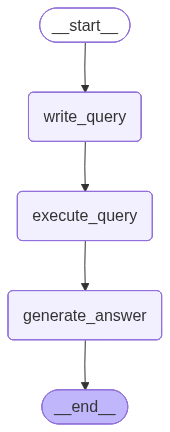

In [24]:
# (5) 업데이트된 write_query 함수 및 SQL 체인 재구성
def write_query_v2(state: State):
    """Generate SQL query to fetch information with updated entity retriever."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
            "entity_info": entity_retriever_tool_v2.invoke(state["question"]),
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}


# 새로운 상태 그래프 생성
graph_builder_v2 = StateGraph(State)

graph_builder_v2.add_node("write_query", write_query_v2)
graph_builder_v2.add_node("execute_query", execute_query)
graph_builder_v2.add_node("generate_answer", generate_answer)

graph_builder_v2.add_edge(START, "write_query")
graph_builder_v2.add_edge("write_query", "execute_query")
graph_builder_v2.add_edge("execute_query", "generate_answer")  
graph_v2 = graph_builder_v2.compile()

# 상태 그래프 시각화
from IPython.display import Image, display
display(Image(graph_v2.get_graph().draw_mermaid_png()))

In [25]:
# (6) SQL 체인 테스트 - 기초자산 및 기초시장 관련 쿼리
print("=== SQL 체인 테스트 1: 기초자산 ===")
for step in graph_v2.stream(
    {"question": "주식을 기초자산으로 하는 ETF는 몇 개인가요?"}, stream_mode="updates"
):
    print(step)

=== SQL 체인 테스트 1: 기초자산 ===
{'write_query': {'query': "SELECT COUNT(*) AS 주식기초자산_ETF_수 FROM ETFsInfo WHERE 기초자산 LIKE '%주식%'"}}
{'execute_query': {'result': '[(694,)]'}}
{'generate_answer': {'answer': '주식을 기초자산으로 하는 ETF는 총 694개입니다.'}}


In [26]:
# SQL 체인 테스트 2: 기초시장
print("\n=== SQL 체인 테스트 2: 기초시장 ===")
for step in graph_v2.stream(
    {"question": "미국 시장을 기초시장으로 하는 ETF는 몇 개인가요?"}, stream_mode="updates"
):
    print(step)


=== SQL 체인 테스트 2: 기초시장 ===
{'write_query': {'query': "SELECT COUNT(*) AS 미국_기초시장_ETF_수 FROM ETFsInfo WHERE 기초시장 LIKE '%미국%'"}}
{'execute_query': {'result': '[(188,)]'}}
{'generate_answer': {'answer': '미국 시장을 기초시장으로 하는 ETF는 총 188개입니다.'}}


In [27]:
# SQL 체인 테스트 3: 기초지수명
print("\n=== SQL 체인 테스트 3: 기초지수명 ===")
for step in graph_v2.stream(
    {"question": "S&P 500 지수를 추종하는 ETF는 무엇인가요?"}, stream_mode="updates"
):
    print(step)


=== SQL 체인 테스트 3: 기초지수명 ===
{'write_query': {'query': "SELECT 종목코드, 종목명, 운용사, 수익률_최근1년 FROM ETFs WHERE 기초지수 LIKE '%S&P 500%' LIMIT 10;"}}
{'execute_query': {'result': "[('360200', 'ACE 미국S&P500', '한국투자신탁운용', 41.85), ('432840', 'HANARO 미국S&P500', '엔에이치아문디자산운용', 41.36), ('449180', 'KODEX 미국S&P500(H)', '삼성자산운용', 25.42), ('379800', 'KODEX 미국S&P500TR', '삼성자산운용', 44.02), ('219480', 'KODEX 미국S&P500선물(H)', '삼성자산운용', 24.98), ('441640', 'KODEX 미국배당커버드콜액티브', '삼성자산운용', 21.89), ('449770', 'KOSEF 미국S&P500', '키움투자자산운용', 42.78), ('449780', 'KOSEF 미국S&P500(H)', '키움투자자산운용', 27.54), ('429760', 'PLUS 미국S&P500', '한화자산운용', 40.17), ('269540', 'PLUS 미국S&P500(H)', '한화자산운용', 27.17)]"}}
{'generate_answer': {'answer': 'S&P 500 지수를 추종하는 ETF는 다음과 같습니다:\n\n1. ACE 미국S&P500 (운용사: 한국투자신탁운용, 최근 1년 수익률: 41.85%)\n2. HANARO 미국S&P500 (운용사: 엔에이치아문디자산운용, 최근 1년 수익률: 41.36%)\n3. KODEX 미국S&P500(H) (운용사: 삼성자산운용, 최근 1년 수익률: 25.42%)\n4. KODEX 미국S&P500TR (운용사: 삼성자산운용, 최근 1년 수익률: 44.02%)\n5. KODEX 미국S&P500선물(H) (운용사: 삼성자산운용, 최근 1년 수

In [28]:
# SQL 체인 테스트 4: 복합 쿼리 (운용사 + 기초자산)
print("\n=== SQL 체인 테스트 4: 복합 쿼리 ===")
for step in graph_v2.stream(
    {"question": "미래에셋에서 운용하는 미국 주식 ETF는 몇 개인가요?"}, stream_mode="updates"
):
    print(step)


=== SQL 체인 테스트 4: 복합 쿼리 ===
{'write_query': {'query': "SELECT COUNT(*) AS 미국주식ETF_수 FROM ETFs WHERE 운용사 LIKE '%미래에셋%' AND 분류체계 LIKE '주식%미국%' LIMIT 10;"}}
{'execute_query': {'result': '[(0,)]'}}
{'generate_answer': {'answer': '미래에셋에서 운용하는 미국 주식 ETF는 현재 없습니다.'}}
